In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
# from torch.utils.tensorboard import SummaryWriter  # 导入TensorBoard的SummaryWriter

from matplotlib import pyplot as plt  # 导入matplotlib库，用于绘图
from utils import plot_image, plot_curve, one_hot  # 导入自定义的一些工具函数，如plot_image, plot_curve, one_hot

BATCH_SIZE = 512  # 大概需要2G的显存
EPOCHS = 3  # 总共训练批次(所有数据丢进去训练，为了实验方便，设置为2次)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 让torch判断是否使用GPU，建议使用GPU环境，因为会快很多

In [3]:
# 下载训练集 shujuji
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

# 下载测试集
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=BATCH_SIZE, shuffle=True)

In [4]:
# 定义卷积神经网络结构
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # batch*1*28*28（每次会送入batch个样本，输入通道数1（黑白图像），图像分辨率是28x28）
        # 下面的卷积层Conv2d的第一个参数指输入通道数，第二个参数指输出通道数，第三个参数指卷积核的大小
        self.conv1 = nn.Conv2d(1, 10, 5)  # 输入通道数1，10个filters 卷积核，核的大小5 filter
        self.conv2 = nn.Conv2d(10, 20, 3)  # 输入通道数10，输出通道数20，核的大小3
        # 下面的全连接层Linear的第一个参数指输入通道数，第二个参数指输出通道数
        self.fc1 = nn.Linear(20 * 10 * 10, 500)  # 输入通道数是2000，输出通道数是500
        self.fc2 = nn.Linear(500, 10)  # 输入通道数是500，输出通道数是10，即10分类

    def forward(self, x):
        in_size = x.size(0)  # 在本例中in_size=512，也就是BATCH_SIZE的值。输入的x可以看成是512*1*28*28的张量。
        out = self.conv1(x)  # batch*1*28*28 -> batch*10*24*24（28x28的图像经过一次核为5x5的卷积，输出变为24x24）
        out = F.relu(out)  # batch*10*24*24（激活函数ReLU不改变形状））
        out = F.max_pool2d(out, 2, 2)  # batch*10*24*24 -> batch*10*12*12（2*2的池化层会减半）
        out = self.conv2(out)  # batch*10*12*12 -> batch*20*10*10（再卷积一次，核的大小是3）
        out = F.relu(out)  # batch*20*10*10
        out = out.view(in_size, -1)  # batch*20*10*10 -> batch*2000（out的第二维是-1，说明是自动推算，本例中第二维是20*10*10）
        out = self.fc1(out)  # 全连接层 batch*2000 -> batch*500
        out = F.relu(out)  # batch*500
        out = self.fc2(out)  # 全连接层 batch*500 -> batch*10
        out = F.log_softmax(out, dim=1)  # 计算log(softmax(x))
        return out

In [5]:
# 训练函数
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    batch_loss = []
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # batch_loss.append(loss.item())
        train_loss_list.append(loss.item())
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    train_accuracy = 100. * correct / total
    # train_acc_list.append(train_accuracy)
    print(f'Epoch: {epoch}, Train_loss:{loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}')
    return train_accuracy

In [6]:
# 测试函数
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    # test_acc_list.append(test_accuracy)
    print(f'Epoch: {epoch}, Test Accuracy: {test_accuracy:.4f}')
    return test_accuracy

In [7]:
# 将训练和模型保存的代码放在这个条件判断中
if __name__ == '__main__':
    # 实例化网络、优化器和损失函数
    model = ConvNet().to(DEVICE)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    train_loss_list = []
    train_acc_list = []
    test_acc_list = []
    # batch_loss_list = []
    # 训练和测试循环
    for epoch in range(1, EPOCHS + 1):
        train_acc = train(model, DEVICE, train_loader, optimizer, epoch)
        test_acc = test(model, DEVICE, test_loader, epoch)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)



Epoch: 1, Train_loss:0.0438, Train Accuracy: 90.7100
Epoch: 1, Test Accuracy: 96.7200
Epoch: 2, Train_loss:0.1556, Train Accuracy: 97.8367
Epoch: 2, Test Accuracy: 98.0800
Epoch: 3, Train_loss:0.0090, Train Accuracy: 98.5867
Epoch: 3, Test Accuracy: 98.7400


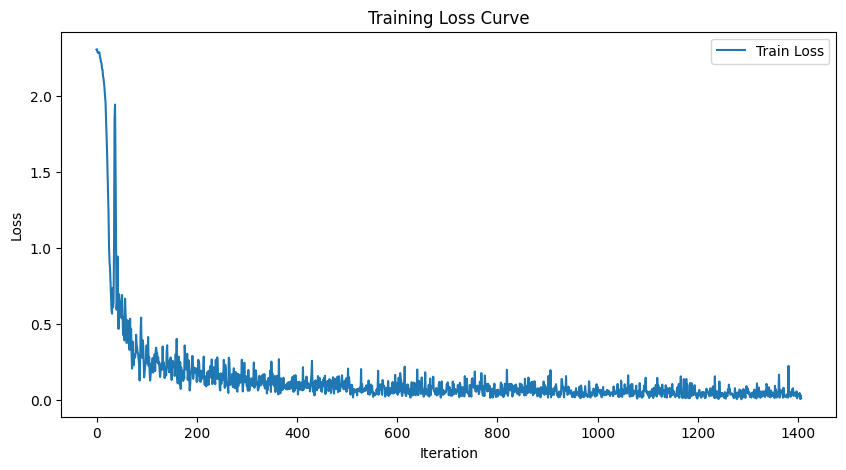

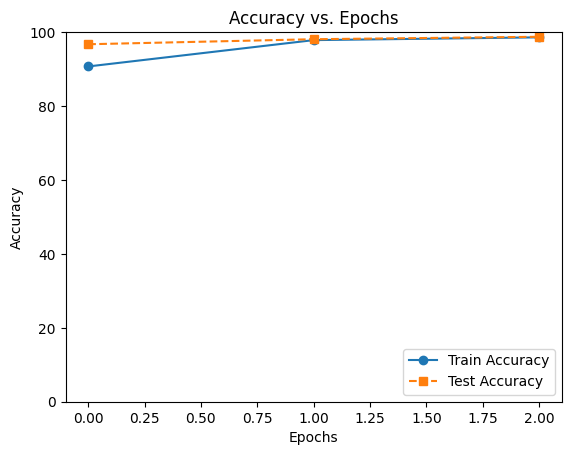

In [8]:
    # 输出loss变化曲线
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_list, label='Train Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend(loc='best')
    plt.show()

    # 绘制训练和测试准确率
    plt.plot(train_acc_list, 'o-', label='Train Accuracy')
    plt.plot(test_acc_list, 's--', label='Test Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Epochs")
    plt.ylim(0, 100.0)
    plt.legend(loc='lower right')
    plt.show()

    # 模型保存 保存整个网络
    torch.save({
        'epoch': EPOCHS,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'Testacc': test_acc,
        'TrainAcc': train_acc,
    }, f"Lenet_model_TrainAcc{train_acc:.1f}_TestAcc{test_acc:.1f}.pth")
# 文件名是一个格式化字符串(f-string)，包含模型名称(Lenet数字识别)，训练轮数(epoch)
# 训练精度(TrainAcc)和测试精度(TestAcc)，以及文件扩展名(.pth)